# Talos Captcha Kraken
Autoencoder+Recurrent Neural Network for Variable Length Captcha Recognition


Yvonne Yang
1006084381

In [ ]:
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import os
import numpy as np
from tqdm.notebook import tqdm
import gc
from torch.utils.data.dataset import Dataset
from PIL import Image
import time
import torch.autograd.profiler as profiler
import json

In [ ]:
use_cuda = True
if use_cuda and not torch.cuda.is_available():
  print("WARNING: CUDA unavailable...Are you sure?")
torch.set_default_tensor_type('torch.cuda.DoubleTensor')
device = "cuda" # change to "cpu" if on cpu
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="max_split_size_mb:128"
torch.cuda.empty_cache()

In [ ]:
local = True
if not local:
  model_folder_path="/content/drive/MyDrive/CNNRNN_models/"
  noisy_data_folder_path="/content/drive/MyDrive/Captcha_Datasets/generated_by_us/captchas_4to8_chars/data320x144"
  pair_data_folder_path="/content/drive/MyDrive/Captcha_Datasets/generated_by_us/captcha_denoised_pairs"
else:
  model_folder_path="results/models/CNNRNN_models/"
  # noisy_data_folder_path="data/data512x256"
  pair_data_folder_path="data/data512x256" # this is the one actually getting used

In [ ]:
####################################################################
####### Essential training configurations and functions ############
####################################################################

INPUT_SIZE=(320, 144)
PAD_TOK="#"
END_TOK="$"
assert len(PAD_TOK) == 1 and len(END_TOK) == 1
MAX_NUM_CHARACTERS=12 
CHAR_CATEGORIES=PAD_TOK + END_TOK + "abcdefghijklmnpqrstuvwxyz" + "23456789"
NUM_CATEGORIES=len(CHAR_CATEGORIES)

def labels_to_encoding(labels : list, one_hot=True):
  """
  if not one_hot: encoding of size (batch_size, MAX_NUM_CHARACTERS) each value is an integer in [0, NUM_CATEGORIES-1]
  if one_hot: encoding of size (batch_size, MAX_NUM_CHARACTERS, NUM_CATEGORIES) where last dimension is one-hot  
  """
  batch_size = len(labels)
  encoded = torch.zeros((batch_size, MAX_NUM_CHARACTERS), device=device)
  for i, label in enumerate(labels):
    for c in label:
      if c not in CHAR_CATEGORIES:
        print("Invalid character:", c)
    encoded_list = [CHAR_CATEGORIES.index(c) for c in label + END_TOK]
    assert len(encoded_list) <= MAX_NUM_CHARACTERS
    encoded_list += [CHAR_CATEGORIES.index(PAD_TOK)]*(MAX_NUM_CHARACTERS-len(encoded_list)) # pad to right size
    encoded[i] = torch.tensor(encoded_list)
  if one_hot:
    encoded = F.one_hot(encoded.to(torch.int64), num_classes=NUM_CATEGORIES)
  return encoded

## Data processing

In [ ]:
# Run this cell to load any pregenerated data

class VariableLengthCaptchaDataset(Dataset):
    def __init__(self, folder, transfms=None, save_path=None):
      self.folder=folder
      self.transforms = transfms
      if transfms is None:
        self.transforms = transforms.Compose([transforms.Resize((INPUT_SIZE[1], INPUT_SIZE[0])), transforms.ToTensor()])
      # Fetching samples as we go turned out to be too slow. Precompute it
      # self.samples = [name for name in os.listdir(folder) \
                      # if not name.startswith(".") and (name.endswith(".jpg") or name.endswith(".png"))]
      if save_path is not None and os.path.isfile(save_path+"_samples.pt"):
        self.samples = torch.load(save_path+"_samples.pt")
      if save_path is not None and os.path.isfile(save_path+"_labels.pt"):
        self.labels = torch.load(save_path+"_labels.pt")
      if save_path is not None and os.path.isfile(save_path+"_encodings.pt"):
        self.encodings = torch.load(save_path+"_encodings.pt")
      else:
        self.labels = []
        for i, name in tqdm(enumerate(os.listdir(folder))):
            if not name.startswith(".") and (name.endswith(".jpg") or name.endswith(".png")):
              img = Image.open(os.path.join(self.folder, name))
              if i == 0:
                self.samples = torch.zeros((len(os.listdir(folder)), 3, INPUT_SIZE[1], INPUT_SIZE[0]))
                self.encodings = torch.zeros((len(os.listdir(folder)), MAX_NUM_CHARACTERS, NUM_CATEGORIES))
              data = self.transforms(img)
              self.samples[i] = data
              name = name.lower().replace(" ","").replace("l", "i").replace("1", "i") # 1, i, l are all the same category
              self.labels.append(name.replace(".png","").replace(".jpg",""))
        self.encodings = labels_to_encoding(self.labels, one_hot=False)
        if save_path is not None:
          torch.save(self.samples, save_path+"_samples.pt")
          torch.save(self.labels, save_path+"_labels.pt")
          torch.save(self.encodings, save_path+"_encodings.pt")

    def __getitem__(self, index):
        data = self.samples[index]
        encod = self.encodings[index]
        
        if use_cuda and torch.cuda.is_available():
          data = data.cuda()
        return (data, encod)

    def get_label(self, index, batch_size=1):
        return self.labels[batch_size*index:batch_size*(index+1)] 

    def __len__(self):
        return len(self.samples) 
print("Loading val data...")
noisy_val_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/val/noisy", save_path=pair_data_folder_path+"/noisy_val_data")
# print("Loading test data...")
# noisy_test_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/test/noisy", save_path=pair_data_folder_path+"/noisy_test_data")
print("Loading train data...")
noisy_train_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/train/noisy")#, save_path=pair_data_folder_path+"/noisy_train_data")
# denoised_val_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/val/denoised", save_path=pair_data_folder_path+"/denoised_val_data")
# denoised_train_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/train/denoised", save_path=pair_data_folder_path+"/denoised_train_data")
# denoised_test_data = VariableLengthCaptchaDataset(pair_data_folder_path+"/test/denoised", save_path=pair_data_folder_path+"/denoised_test_data")

In [ ]:
#print("noisy train data size: {:.2f} GB".format(float(noisy_train_data.samples.element_size()*noisy_train_data.samples.nelement()/1e9)))
# lol ok no saving then

noisy train data size: 2.21 GB


Train samples: 3997
Val samples: 750
Test samples: 750


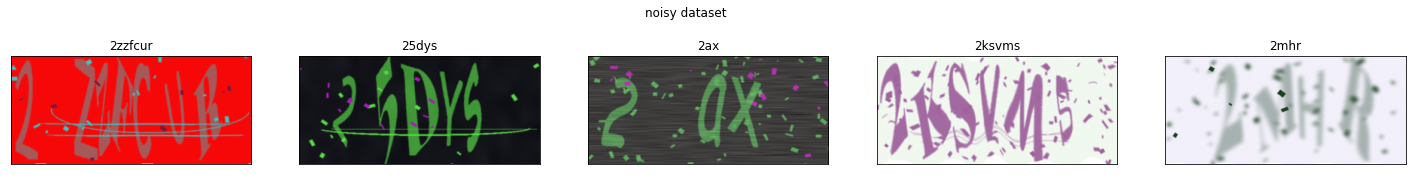

In [ ]:
def show_data_info(data, batch=5, noisy=True):
  noisy_ = "noisy" if noisy else "denoised"
  data_loader = torch.utils.data.DataLoader(data,  batch_size=batch)

  # Count number of samples
  print ("Train samples:", len([f for f in os.listdir(pair_data_folder_path+"/train/"+noisy_) if os.path.isfile(os.path.join(pair_data_folder_path+"/train/"+noisy_, f))]))
  print ("Val samples:", len([f for f in os.listdir(pair_data_folder_path+"/val/"+noisy_) if os.path.isfile(os.path.join(pair_data_folder_path+"/val/"+noisy_, f))]))
  print ("Test samples:", len([f for f in os.listdir(pair_data_folder_path+"/test/"+noisy_) if os.path.isfile(os.path.join(pair_data_folder_path+"/test/"+noisy_, f))]))

  # Visualize the dataset
  def visualize_data(images, labels, title=None,  n_per_label=3):
    fig = plt.figure(figsize=(25, 3))
    fig.suptitle(title)
    if use_cuda and torch.cuda.is_available():
      images = images.cpu()
    for idx in np.arange(n_per_label*5):
        ax = fig.add_subplot(n_per_label, 5, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx],(1, 2, 0)))
        ax.set_title(labels[idx])

  images, _ = iter(data_loader).next()
  labels = data.get_label(0, batch_size=batch)
  visualize_data(images, labels, title=noisy_+" dataset",n_per_label=1)

show_data_info(noisy_train_data, batch=5)
# batch=5
# denoised_train_loader = torch.utils.data.DataLoader(denoised_train_data,batch_size=batch)
# images, labels = iter(denoised_train_loader).next()
# visualize_data(images, labels, title="Denoised Dataset",  n_per_label=1)

## Models

In [ ]:
assert len(PAD_TOK) == 1 and len(END_TOK) == 1
class RNNDec(nn.Module):
    def __init__(self, 
                 fc_mid=None, fc_out=None, fc_dropout=0.5,
                 rnn_type=nn.LSTMCell, rnn_input_sz=1000, rnn_hd_sz=NUM_CATEGORIES, 
                 rnn_nonlin="tanh", rnn_dropout=0.8):
      """
      rnn_type = nn.RNNCell or nn.LSTMCell or nn.GRUCell
      rnn_nonlin = "tanh" or "relu"
      """
      super(RNNDec, self).__init__()
      self.seq_len = MAX_NUM_CHARACTERS # "sequence length" = max number of characters
      self.fc_dropout = fc_dropout
      self.rnn_hd_sz = rnn_hd_sz
      self.rnn_input_sz = rnn_input_sz

      self.dropout = nn.Dropout(fc_dropout)
      self.fc_mids = None if fc_mid is None else\
                     nn.ModuleList([nn.Linear(fc_mid[i-1], fc_mid[i]) \
                                    for i in range(1, len(fc_mid))])
      self.h0 = nn.Parameter(torch.zeros((batch_size, rnn_hd_sz), dtype=torch.float64, requires_grad=True))
      if rnn_type == nn.RNNCell:
        self.rnn_type = "rnn"
        self.rnn = rnn_type(input_size=rnn_input_sz,
                            hidden_size=rnn_hd_sz,
                            nonlinearity=rnn_nonlin,
                            dtype=torch.float64)
      elif rnn_type == nn.LSTMCell:
        self.c0 = nn.Parameter(torch.zeros((batch_size, rnn_hd_sz), dtype=torch.float64, requires_grad=True))
        self.rnn_type = "lstm"
        self.rnn = rnn_type(input_size=rnn_input_sz,
                            hidden_size=rnn_hd_sz,
                            dtype=torch.float64)
      elif rnn_type == nn.GRUCell:
        self.rnn_type="gru"
        self.rnn = rnn_type(input_size=rnn_input_sz,
                            hidden_size=rnn_hd_sz,
                            dtype=torch.float64)
      self.fc_outs = None if fc_out is None else\
                     nn.ModuleList([nn.Linear(fc_out[i-1], fc_out[i]) \
                                   for i in range(1, len(fc_out))])
     

    def forward(self, x, target=None, teach_prob=1):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1) 
        x = self.dropout(x)
        if self.fc_mids:
          for fc in self.fc_mids:
            x = fc(x)
            x = self.dropout(x)

        x = x.view(self.seq_len, batch_size, -1) 
        if teach_prob < 1:
          target = F.one_hot(target.to(torch.int64), num_classes=NUM_CATEGORIES)
          target = target.view(self.seq_len, batch_size, -1) 
        # assert target[0].shape == self.h0.shape
        h = self.h0[0:batch_size]
        if self.rnn_type != "lstm":
          out = torch.zeros((MAX_NUM_CHARACTERS, batch_size, self.rnn_hd_sz))
          for i in (MAX_NUM_CHARACTERS):
            if torch.rand(1).item() > teach_prob and i > 1: # teacher forcing
              h = target[i-1].double()
            h = self.rnn(x[i], h)
            out[i] = h
        else:
          c = self.c0[0:batch_size]
          out = torch.zeros((MAX_NUM_CHARACTERS, batch_size, self.rnn_hd_sz))
          for i in range(MAX_NUM_CHARACTERS):
            if torch.rand(1).item() > teach_prob and i > 1: # teacher forcing
              h = target[i-1].double()
            h, c = self.rnn(x[i], (h, c))
            out[i] = h
        
        x = out.view(batch_size, MAX_NUM_CHARACTERS, self.rnn_hd_sz)
        if self.fc_outs:
          for fc in self.fc_outs:
            x = fc(x)
            x = self.dropout(x)
        return x

    def init_weights(self):
        for m in self.modules():
            if type(m) in [nn.GRUCell, nn.LSTMCell, nn.RNNCell]:
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        torch.nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        torch.nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        if m == nn.LSTM: # forget gate to 1
                          param.data.fill_(1)
                        else:
                          param.data.fill_(0)

#### CNN+RNN

In [ ]:
assert len(PAD_TOK) == 1 and len(END_TOK) == 1
class CNNEnc_RNNDec(nn.Module):
    def __init__(self, conv_channels=None, kernel_sizes=None, 
                 fc_mid=[286416, 1000], fc_out=None,
                 rnn_type=nn.RNN, rnn_layers=2, rnn_input_sz=1000, rnn_hd_sz=NUM_CATEGORIES, 
                 rnn_nonlin="tanh", rnn_dropout=0.8):
      """
      conv_layers >= 2, fc_layers >= 0, rnn_layers >=1,
      cnn_nonlin = nn.ReLu() or nn.LeakyReLu()
      rnn_type = nn.RNN or nn.LSTM or nn.GRU
      rnn_nonlin = "tanh" or "relu"
      """
      super(CNNEnc_RNNDec, self).__init__()
      if conv_channels is None:
        conv_channels = [3, 9, 27, 81]
      if kernel_sizes is None:
        kernel_sizes = [3,3,5]
      self.seq_len = MAX_NUM_CHARACTERS # "sequence length" = max number of characters
      self.rnn_layers = rnn_layers
      self.rnn_hd_sz = rnn_hd_sz

      self.convs = nn.ModuleList([nn.Conv2d(in_channels = conv_channels[i-1], 
                                  out_channels = conv_channels[i], 
                                  kernel_size = kernel_sizes[i-1])
                                  for i in range(1, len(conv_channels))])
      self.fc_mids = None if fc_mid is None else\
                     nn.ModuleList([nn.Linear(fc_mid[i-1], fc_mid[i]) \
                                    for i in range(1, len(fc_mid))])
      if rnn_type == nn.RNN:
        self.rnn_type = "rnn"
        self.rnn = rnn_type(batch_first=True,
                            num_layers=rnn_layers,
                            input_size=rnn_input_sz,
                            hidden_size=rnn_hd_sz,
                            nonlinearity=rnn_nonlin,
                            dropout=rnn_dropout)
      elif rnn_type == nn.LSTM:
        self.rnn_type = "lstm"
        self.rnn = rnn_type(batch_first=True,
                            num_layers=rnn_layers,
                            input_size=rnn_input_sz,
                            hidden_size=rnn_hd_sz,
                            dropout=rnn_dropout)
      elif rnn_type == nn.GRU:
        self.rnn_type="gru"
        self.rnn = rnn_type(batch_first=True,
                            num_layers=rnn_layers,
                            input_size=rnn_input_sz,
                            hidden_size=rnn_hd_sz,
                            dropout=rnn_dropout)
      self.fc_outs = None if fc_out is None else\
                     nn.ModuleList([nn.Linear(fc_out[i-1], fc_out[i]) \
                                   for i in range(1, len(fc_out))])
     

    def forward(self, x):
        for conv in self.convs:
          x = nn.ReLU()(conv(x))
        x = x.view(x.shape[0], self.seq_len, -1) 
        if self.fc_mids:
          for fc in self.fc_mids:
            x = fc(x)

        if self.rnn_type != "lstm":
          h0 = torch.ones((self.rnn_layers, x.shape[0], self.rnn_hd_sz)) # output is probits
          x, h = self.rnn(x, h0)
        else:
          x, h = self.rnn(x) # h is (h,c)
        if self.fc_outs:
          for fc in self.fc_outs:
            x = fc(x)
        return x, h

    def decode(self, x):
        if self.rnn_type != "lstm":
          h0 = torch.ones((self.rnn_layers, x.shape[0], self.rnn_hd_sz)) # output is probits
          x, h = self.rnn(x, h0)
        else:
          x, h = self.rnn(x) # h is (h,c)
        if self.fc_outs:
          for fc in self.fc_outs:
            x = fc(x)
        return x, h

    def init_weights(self):
        for m in self.modules():
            if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        torch.nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        torch.nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        if m == nn.LSTM: # forget gate to 1
                          param.data.fill_(1)
                        else:
                          param.data.fill_(0)

### scratch (tests for model, label_to_encoding, CrossEntropy)

In [ ]:
# test
CNNRNN_test = CNNEnc_RNNDec()
print(CNNRNN_test)
val_loader = torch.utils.data.DataLoader(noisy_val_data, 
                                          batch_size=5, 
                                          num_workers=0,
                                          shuffle=False)
data, label = iter(val_loader).next()
out, h = CNNRNN_test(data)
print(out)
readable = out.argmax(dim=-1)
print(readable.shape)
print(readable)

CNNEnc_RNNDec(
  (convs): ModuleList(
    (0): Conv2d(3, 9, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(9, 27, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(27, 81, kernel_size=(5, 5), stride=(1, 1))
  )
  (fc_mids): ModuleList(
    (0): Linear(in_features=286416, out_features=1000, bias=True)
  )
  (rnn): RNN(1000, 34, num_layers=2, batch_first=True, dropout=0.8)
)
tensor([[[-8.4908e-01, -2.2217e-01,  3.4092e-01,  ..., -3.7054e-01,
           7.3447e-02, -5.7263e-01],
         [-2.5137e-01,  3.3739e-01,  8.0889e-01,  ...,  1.9295e-01,
          -2.1371e-01, -8.0478e-01],
         [ 2.4244e-01, -3.2249e-01,  2.5835e-01,  ...,  3.6763e-01,
          -5.4905e-03, -6.0753e-01],
         ...,
         [ 3.8807e-01, -3.3533e-02, -4.1020e-01,  ...,  2.7577e-01,
           2.6513e-01, -1.9791e-01],
         [ 3.9277e-01,  1.9491e-01,  4.4391e-01,  ...,  5.3374e-01,
           3.3992e-01,  2.2719e-01],
         [-2.4275e-01,  7.0420e-02,  4.7606e-01,  ...,  1.9260e-01,
           8

In [ ]:
label = noisy_val_data.get_label(0, batch_size=5)
print(label)
print(labels_to_encoding(label, one_hot=False))
print(labels_to_encoding(label))
print(labels_to_encoding(label).argmax(dim=-1)) # encoding back to labels

['2fvma', '22gn', '28c9va', '2as', '2ai']
tensor([[26.,  7., 21., 13.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [26., 26.,  8., 14.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [26., 32.,  4., 33., 21.,  2.,  1.,  0.,  0.,  0.,  0.,  0.],
        [26.,  2., 18.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [26.,  2., 10.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 1, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 0, 0,  ..., 0, 0, 0],
 

In [ ]:
pred = torch.FloatTensor([
                     [[0, 0.1, 0, 0], [0.02, 0, 0, 0]]
])
true = torch.FloatTensor([
                     [[0, 1, 0, 0], [1, 0, 0, 0]]
])
print(pred.flatten(end_dim=1))
print(nn.CrossEntropyLoss(reduction='sum')(pred.flatten(end_dim=1), true.flatten(end_dim=1)))
pred = torch.FloatTensor([
                     [0, 0.1, 0, 0]
])
true = torch.FloatTensor([
                     [0, 1, 0, 0]
])
print(nn.CrossEntropyLoss()(pred, true))
pred = torch.FloatTensor([
                     [0.02, 0, 0, 0]
])
true = torch.FloatTensor([
                    [1, 0, 0, 0]
])
print(nn.CrossEntropyLoss()(pred, true))

tensor([[0.0000, 0.1000, 0.0000, 0.0000],
        [0.0200, 0.0000, 0.0000, 0.0000]], device='cpu')
tensor(2.6836, device='cpu')
tensor(1.3122, device='cpu')
tensor(1.3713, device='cpu')


In [ ]:
# maskedCELoss
maskedCELoss = nn.NLLLoss(ignore_index=CHAR_CATEGORIES.index(PAD_TOK))
m = nn.LogSoftmax(dim=1)
pred = torch.tensor([[27, 4, 3, 2, 21, 5, 6, 3, 1, 5, 6, 7]], device=device) # matching
pred = F.one_hot(pred.to(torch.int64), num_classes=NUM_CATEGORIES)
truth = torch.tensor([27, 4, 3, 2, 21, 5, 6, 3, 1, 0, 0, 0], device=device)
# truth = F.one_hot(truth.to(torch.int64), num_classes=NUM_CATEGORIES)
print("loss: ", maskedCELoss(m(pred.flatten(end_dim=1).to(torch.float64)), truth).item(), "accuracy: ", get_accuracy_single_batch_CNNRNN(pred, truth))
pred = torch.tensor([[27, 4, 3, 2, 21, 5, 6, 3, 1, 24, 30, 18]], device=device) # also matching
pred = F.one_hot(pred.to(torch.int64), num_classes=NUM_CATEGORIES)
truth = torch.tensor([27, 4, 3, 2, 21, 5, 6, 3, 1, 0, 0, 0], device=device)
# truth = F.one_hot(truth.to(torch.int64), num_classes=NUM_CATEGORIES)
print("loss: ", maskedCELoss(m(pred.flatten(end_dim=1).to(torch.float64)), truth).item(), "accuracy: ", get_accuracy_single_batch_CNNRNN(pred, truth))
pred = torch.tensor([[27, 4, 3, 2, 21, 5, 6, 3, 2, 24, 30, 18]], device=device) # worse
pred = F.one_hot(pred.to(torch.int64), num_classes=NUM_CATEGORIES)
truth = torch.tensor([27, 4, 3, 2, 21, 5, 6, 3, 1, 0, 0, 0], device=device)
# truth = F.one_hot(truth.to(torch.int64), num_classes=NUM_CATEGORIES)
print("loss: ", maskedCELoss(m(pred.flatten(end_dim=1).to(torch.float64)), truth).item(), "accuracy: ", get_accuracy_single_batch_CNNRNN(pred, truth))
pred = torch.tensor([[27, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0], # much worse
                     [1, 2, 1, 31, 32, 15, 19, 2, 26, 23, 1, 2]], device=device) # worst
pred = F.one_hot(pred.to(torch.int64), num_classes=NUM_CATEGORIES)
truth = torch.tensor([[27, 4, 3, 2, 21, 5, 6, 3, 1, 0, 0, 0],
                      [27, 4, 3, 2, 21, 5, 6, 3, 1, 0, 0, 0]], device=device)
# truth = F.one_hot(truth.to(torch.int64), num_classes=NUM_CATEGORIES)
print("loss: ", maskedCELoss(m(pred.flatten(end_dim=1).to(torch.float64)), truth.flatten()).item(), "accuracy: ", get_accuracy_single_batch_CNNRNN(pred, truth))

loss:  2.5756626537444336 accuracy:  tensor(1.)
loss:  2.5756626537444336 accuracy:  tensor(1.)
loss:  2.6867737648555448 accuracy:  tensor(0.8889)
loss:  3.3534404315222104 accuracy:  tensor(0.2222)


##Training

### Train CNN-RNN

In [ ]:
def maskedCELoss(pred, truth):
  """pred and truth are both one-hot: size (batch_size, MAX_NUM_CHARACTERS, NUM_CATEGORIES) """
  encod = truth.argmax(dim=-1) # 0-mask the padded part of "truth" -> doesn't matter what model outputs for padded part
  cond = torch.tensor(encod == CHAR_CATEGORIES.index(PAD_TOK), device=device)
  mask = torch.where(cond, torch.zeros(encod.shape), torch.ones(encod.shape))
  mask = mask.repeat_interleave(NUM_CATEGORIES, dim=1)
  pred = pred.flatten(end_dim=1)
  truth = truth.flatten(end_dim=1)
  loss = nn.CrossEntropyLoss()(pred*mask.view_as(pred), truth*mask.view_as(truth))
  return loss

def get_accuracy_CNNRNN(model, data_loader, debug=False):
  correct = 0
  total = 0
  for data, target in data_loader:

    if use_cuda and torch.cuda.is_available():
      data = data.cuda()
      target = target.cuda()

    out, h = model(data)

    mask = torch.where(target == CHAR_CATEGORIES.index(PAD_TOK), torch.zeros(target.shape, device=device), torch.ones(target.shape, device=device))
    pred = out.argmax(dim=-1)
    num_pads = torch.numel(mask) - mask.sum()
    correct += (pred*mask).eq(target*mask).sum().item() - num_pads
    total += mask.sum()

  if debug:
    print("pred:", pred)
    print("target:", target)

  return correct/total

In [ ]:
if use_cuda and torch.cuda.is_available():
  num_workers = 0
  shuffle = False
else:
  num_workers=2
  shuffle=True

def build_and_train_CNNRNN(model_path=None,
                        noisy=True, num_epochs=5, batch_size=64, learning_rate=1e-3,
                        conv_channels=None, kernel_sizes=None, 
                        fc_mid=None, fc_out=None,
                        rnn_type=nn.RNN, rnn_layers=2, rnn_input_sz=53352, rnn_hd_sz=NUM_CATEGORIES, 
                        rnn_nonlin="tanh", rnn_dropout=0.8,
                        from_epoch=1, save_every=5, use_cuda=False):
    # default
    if conv_channels is None:
      conv_channels = [3, 9, 27, 81]
    if kernel_sizes is None:
      kernel_sizes = [3,3,5]

    # model path
    if model_path is None:
      cv = "_".join(str(i) for i in conv_channels)
      fcm=""
      fco=""
      if fc_mid is not None:
        fcm = "_".join(str(i) for i in fc_mid)
      if fc_out is not None:
        fco = "_".join(str(i) for i in fc_out)
      model_path="n" + f"_lr={learning_rate}_bs={batch_size}_rt={rnn_type.__name__}_do={rnn_dropout}_cv={cv}_fcm={fcm}_fco={fco}" if noisy \
            else "d" + f"_lr={learning_rate}_bs={batch_size}_rt={rnn_type.__name__}_do={rnn_dropout}_cv={cv}_fcm={fcm}_fco={fco}"
    os.makedirs(model_folder_path+model_path, exist_ok=True)

    # save parameters to json file
    params = locals()
    params["rnn_type"] = rnn_type.__name__
    with open(os.path.join(model_folder_path, model_path, 'params.json'), 'w') as fp:
      json.dump(params, fp, indent=4)
    
    if use_cuda:
      torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
    torch.manual_seed(360)
    
    if noisy:
      train_loader = torch.utils.data.DataLoader(noisy_train_data, 
                                                batch_size=batch_size, 
                                                num_workers=num_workers,
                                                shuffle=shuffle)
      val_loader = torch.utils.data.DataLoader(noisy_val_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=shuffle)
    else:
      train_loader = torch.utils.data.DataLoader(denoised_train_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=shuffle)
      val_loader = torch.utils.data.DataLoader(denoised_val_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=shuffle)
    model = CNNEnc_RNNDec(conv_channels=conv_channels, kernel_sizes=kernel_sizes,
                        fc_mid=fc_mid, fc_out=fc_out,
                        rnn_type=rnn_type, rnn_layers=rnn_layers, rnn_input_sz=rnn_input_sz, rnn_hd_sz=rnn_hd_sz, 
                        rnn_nonlin=rnn_nonlin, rnn_dropout=rnn_dropout)
    model.init_weights()
    if from_epoch > 0:
      model.load_state_dict(torch.load(os.path.join(model_folder_path,model_path,f"_{from_epoch}.pt")))

    if use_cuda and torch.cuda.is_available():
      model.cuda()

    print("training...")
    train_CNNRNN(model, train_loader, val_loader,
             model_path=model_path,
             noisy=noisy, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate,
             from_epoch=from_epoch,save_every=save_every, use_cuda=use_cuda)
    
    if use_cuda and torch.cuda.is_available():
      del model
      del train_loader
      del val_loader
      gc.collect()
      torch.cuda.empty_cache()
    

def train_CNNRNN(model, train_loader, val_loader,
             model_path=None,
             noisy=True, num_epochs=5, batch_size=64, learning_rate=1e-3,
             from_epoch=0, save_every=5, use_cuda=False):
    torch.manual_seed(360)
    criterion = nn.NLLLoss(ignore_index=CHAR_CATEGORIES.index(PAD_TOK))
    logsoftmax = nn.LogSoftmax(dim=1)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)
    outputs, losses, train_acc, val_acc = [], [], [], []

    
    for epoch in tqdm(range(from_epoch+1, num_epochs+from_epoch+1)):
        num_batches = 0
        for data, label in tqdm(train_loader, leave=True):
            out, _ = model(data)
            loss = criterion(logsoftmax(out.flatten(end_dim=1)), label.to(torch.int64).flatten())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if use_cuda and torch.cuda.is_available():
              loss = loss.cuda()

            losses.append(loss.item())

            # minibatch train acc
            mask = torch.where(label == CHAR_CATEGORIES.index(PAD_TOK), torch.zeros(label.shape, device=device), torch.ones(target.shape, device=device))
            pred = out.argmax(dim=-1)
            num_pads = torch.numel(mask) - mask.sum()
            mini_batch_correct += (pred*mask).eq(target*mask).sum().item() - num_pads
            Mini_batch_total += mask.sum()
            train_acc.append(mini_batch_correct / Mini_batch_total)

            val_acc.append(val_acc[-1] if len(val_acc)> 0 else 0)
            num_batches += 1

        val_acc=val_acc[:-1]
        v_acc = get_accuracy_CNNRNN(model, val_loader)
        val_acc.append(v_acc.item())  # compute validation accuracy    
        print('Epoch:{}, Loss:{:.4f}, Train acc:{:.4f}, Val acc:{:.4f}'.format(epoch, float(loss), train_acc[-1], v_acc))
        
        if epoch % save_every == 0 or epoch == 1 or epoch == from_epoch+num_epochs:
            torch.save(model.state_dict(), model_folder_path+model_path+"/_"+str(epoch)+".pt")

    np.savetxt(model_folder_path+model_path+f"/loss_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                losses,
                delimiter =", ", 
                fmt ='% s')
    np.savetxt(model_folder_path+model_path+f"/tacc_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                train_acc,
                delimiter =", ", 
                fmt ='% s')
    np.savetxt(model_folder_path+model_path+f"/vacc_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                val_acc,
                delimiter =", ", 
                fmt ='% s')
    
    # plotting
    plt.title("Training Curve")
    iters = range(len(losses))
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig(model_folder_path+model_path+f"/loss_{from_epoch+1}_to_{from_epoch+num_epochs}.jpg")
    plt.show()

    iters = np.linspace(from_epoch+1, from_epoch+num_epochs, num=num_batches*(num_epochs))
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.savefig(model_folder_path+model_path+f"/acc_{from_epoch+1}_to_{from_epoch+num_epochs}_acc={val_acc[-1]:.2f}.jpg")
    plt.show()

    print("Final Training Accuracy: {}".format(get_accuracy_CNNRNN(model, train_loader)))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
torch.cuda.empty_cache()
gc.collect()

30

training...


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:1, Loss:3.4694, Train acc:0.0753, Val acc:0.1344


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:2, Loss:3.4521, Train acc:0.0841, Val acc:0.1463


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:3, Loss:3.4400, Train acc:0.0833, Val acc:0.1474


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:4, Loss:3.4234, Train acc:0.0857, Val acc:0.1457


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:5, Loss:3.4084, Train acc:0.0841, Val acc:0.1459


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:6, Loss:3.3983, Train acc:0.0841, Val acc:0.1451


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:7, Loss:3.3910, Train acc:0.0841, Val acc:0.1448


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:8, Loss:3.3797, Train acc:0.0849, Val acc:0.1446


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:9, Loss:3.3858, Train acc:0.0853, Val acc:0.1449


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:10, Loss:3.3830, Train acc:0.0853, Val acc:0.1461


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:11, Loss:3.3807, Train acc:0.0849, Val acc:0.1453


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:12, Loss:3.3731, Train acc:0.0857, Val acc:0.1459


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:13, Loss:3.3689, Train acc:0.0853, Val acc:0.1463


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:14, Loss:3.3664, Train acc:0.0861, Val acc:0.1467


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:15, Loss:3.3656, Train acc:0.0877, Val acc:0.1473


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:16, Loss:3.3637, Train acc:0.0853, Val acc:0.1478


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:17, Loss:3.3591, Train acc:0.0865, Val acc:0.1482


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:18, Loss:3.3556, Train acc:0.0869, Val acc:0.1503


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:19, Loss:3.3508, Train acc:0.0905, Val acc:0.1524


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:20, Loss:3.3468, Train acc:0.0869, Val acc:0.1517


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:21, Loss:3.3387, Train acc:0.0905, Val acc:0.1536


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:22, Loss:3.3326, Train acc:0.0905, Val acc:0.1576


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:23, Loss:3.3315, Train acc:0.0889, Val acc:0.1567


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:24, Loss:3.3270, Train acc:0.0873, Val acc:0.1572


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:25, Loss:3.3220, Train acc:0.0913, Val acc:0.1580


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:26, Loss:3.3212, Train acc:0.0905, Val acc:0.1594


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:27, Loss:3.3168, Train acc:0.0938, Val acc:0.1571


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:28, Loss:3.3186, Train acc:0.0897, Val acc:0.1557


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:29, Loss:3.3136, Train acc:0.0933, Val acc:0.1551


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch:30, Loss:3.3112, Train acc:0.0893, Val acc:0.1563


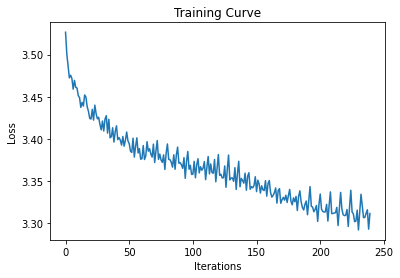

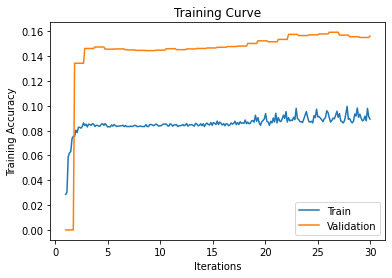

Final Training Accuracy: 0.1563691347837448
Final Validation Accuracy: 0.15628604590892792


In [ ]:
build_and_train_CNNRNN(model_path=None,
                        noisy=True, num_epochs=30, batch_size=256, learning_rate=1e-3,
                        conv_channels=[3, 9, 27, 81], kernel_sizes=[3, 3, 5],
                        fc_mid=[286416, 1000], fc_out=None,
                        rnn_type=nn.LSTM, rnn_layers=2, rnn_input_sz=1000, rnn_hd_sz=NUM_CATEGORIES, 
                        rnn_nonlin="tanh", rnn_dropout=0.8,
                        from_epoch=0, save_every=5, use_cuda=True)

In [ ]:
def get_accuracy_single_batch_CNNRNN(pred, target, debug=False, data=None, batch_size=None, visualize_errs=False):
  """pred is one-hot BSxMAX_NUM_CHARACTERSxNUM_CATEGORIES, true_encod is BSxMAX_NUM_CHARACTERS"""
  mask = torch.where(target == CHAR_CATEGORIES.index(PAD_TOK), torch.zeros(target.shape, device=device), torch.ones(target.shape, device=device))
  pred = pred.argmax(dim=-1)
  num_pads = torch.numel(mask) - mask.sum()
  correct = (pred*mask).eq(target*mask).sum().item() - num_pads
  total = mask.sum()
  if debug:
    print("pred:", pred)
    print("target:", target)

  if visualize_errs: # get up to 10 samples that were predicted wrong
    if data is None or batch_size is None:
      raise Exception("Must pass in data and batch_size for visual")
    label = noisy_val_data.get_label(0, batch_size=batch_size)
    errors, corrects = [], []
    for i in range(pred.shape[0]):
      pred_label = "".join(CHAR_CATEGORIES[idx] for idx in pred[i].to(torch.int64))
      print(pred_label, label[i])
      if not torch.all(pred[i].eq(target[i])) and len(errors) < 10:
        errors.append((data[i], pred_label, label[i]))
      if torch.all(pred[i].eq(target[i])) and len(corrects) < 10:
        corrects.append((data[i], pred_label, label[i]))
    fig = plt.figure(figsize=(25, 4))
    fig.suptitle("Wrong predictions")
    for i in range(len(errors)):
      data, pred_label, label = errors[i]
      if use_cuda and torch.cuda.is_available():
        data = data.cpu()
      ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(data,(1, 2, 0)))
      ax.set_title("pred="+pred_label.replace("$", "\$")+" target="+label)
    
    
    fig = plt.figure(figsize=(25, 4))
    fig.suptitle("Correct predictions")
    for i in range(len(corrects)):
      data, pred_label, label = corrects[i]
      if use_cuda and torch.cuda.is_available():
        data = data.cpu()
      ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(data,(1, 2, 0)))
      ax.set_title("pred="+pred_label.replace("$", "\$")+" target="+label)
  return correct/total

tybz$i$$$$qj 2fvma
cyny$$$$$$u9 22gn
tkhv$6n$z$e# 28c9va
tdxtj$$$w$zc 2as
syhv$$jj$nqw 2ai
si6y$m$$r$mi 2bah
3dgvj6$$c$yc 2bxmt33y
bkez$$$$p3uf 2enfwaa
tdzd$$df$jum 2h4emp
3ypkn$jp$$hm 2htb
tyczj$zy$$z$ 2ksx
zchc$$$$$$di 2ix
cygz$$$$$jx6 2q9tat42
tygycz$$$$eg 2wpzbwk9
tygz$$$$$bq8 3yn
rybz$$b$n$3s 3cn
tyhhj$$$$$uq 3kwn
rdizz$$$$$d7 33bp
cy7y$a$$$mq$ 36zev
rybya$r$$$gr 372pbuzqf
tj$y$j$$$$kr 3dhf4suu
ryh5j$$$g$qi 3gtw5my
tc$$$ej$$$ea 3mpgqnxz
tycy$$$$y$wy 3ujcj
ryc$$$j$$$8i 4uif9
rdgcy$b$$$gj 4vv
tdh$$p$$$mci 4dnvkq
zda$j$$$$$q# 4hkv2zz7
ryt5$$$$$$8c 4hyj
shty$$$$$$q4 4jxm7
xkj7$$m$$$qt 4kcufh
tsjp$$$$$$kc 4kyrym
Accuracy over 1 batch:  tensor(0.0931)


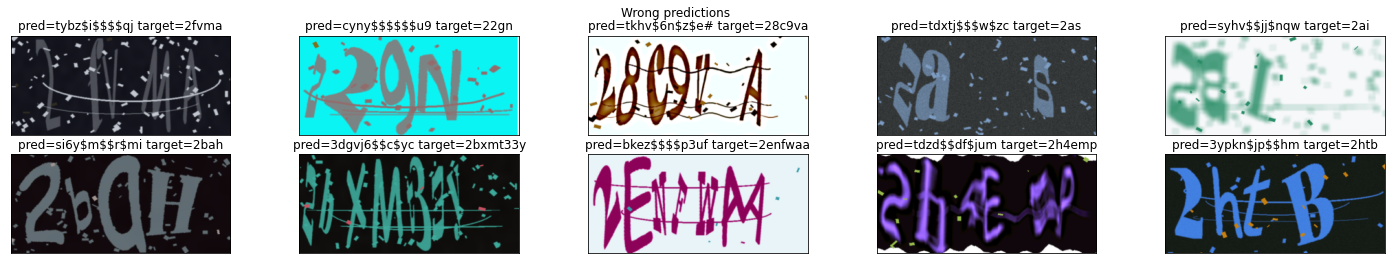

<Figure size 1800x288 with 0 Axes>

In [ ]:
# Visualize errors
batch=32
tmp_model = CNNEnc_RNNDec(conv_channels=None, kernel_sizes=None, 
                 fc_mid=None, fc_out=None,
                 rnn_type=nn.RNN, rnn_layers=2, rnn_input_sz=286416, rnn_hd_sz=NUM_CATEGORIES, 
                 rnn_nonlin="tanh", rnn_dropout=0.8)
tmp_model.load_state_dict(torch.load("results/models/CNNRNN_models/n_lr=0.0001_bs=128_rt=RNN_do=0.8_cv=3_9_27_81_fcm=_fco=/_30.pt"))
val_loader = torch.utils.data.DataLoader(noisy_val_data, 
                                          batch_size=batch, 
                                          num_workers=0,
                                          shuffle=False)
data, encod = iter(val_loader).next()
out, h = tmp_model(data)
print("Accuracy over 1 batch: ", get_accuracy_single_batch_CNNRNN(out, encod, data=data, batch_size=batch, visualize_errs=True))
del tmp_model, val_loader, data, out, h, encod

poopy accuracy

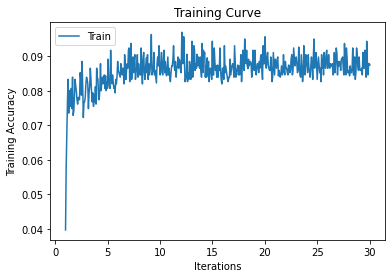

In [ ]:
# plot accuracy
import matplotlib.cbook as cbook
with cbook.get_sample_data('G:/Talos-Captcha-Kraken/results/models/CNNRNN_models/n_lr=0.0001_bs=128_rt=LSTM_do=0.8_cv=3_9_27_81_fcm=286416_1000_fco=/tacc_1_to_30.csv') as file:
    train_acc = np.loadtxt(file)
iters = np.linspace(1, 30, num=480)
plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')

### Use pretrained convolutional network as encoder

In [ ]:
# grab features and store them
import torchvision.models as models
tsfnet = models.alexnet(pretrained=True)
batch_size=256
num_workers=0
train_loader = torch.utils.data.DataLoader(noisy_train_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False, pin_memory=False)
val_loader = torch.utils.data.DataLoader(noisy_val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False, pin_memory=False)
def compute_backbone_features(tsf_net, data_loader):
  computed_features = []
  for imgs, labels in tqdm(data_loader):
    feature=tsfnet.features(imgs.cuda())
    feature=feature.detach()
    assert feature.requires_grad==False
    computed_features.append(feature)
  return computed_features

computed_features = compute_backbone_features(tsfnet, train_loader)
val_computed_features = compute_backbone_features(tsfnet, val_loader)
print("Train features shape:", len(computed_features), "*", computed_features[0].shape)
print("Val features shape:", len(val_computed_features), "*", val_computed_features[0].shape)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Train features shape: 16 * torch.Size([256, 256, 3, 9])
Val features shape: 3 * torch.Size([256, 256, 3, 9])


In [ ]:
def get_accuracy_TSFRNN(model, data_loader, features, debug=False):
  correct = 0
  total = 0
  for i, (data, target) in enumerate(data_loader):

    if use_cuda and torch.cuda.is_available():
      data = data.cuda()
      target = target.cuda()

    out = model(features[i])

    mask = torch.where(target == CHAR_CATEGORIES.index(PAD_TOK), torch.zeros(target.shape, device=device), torch.ones(target.shape, device=device))
    pred = out.argmax(dim=-1)
    num_pads = torch.numel(mask) - mask.sum()
    correct += (pred*mask).eq(target*mask).sum().item() - num_pads
    total += mask.sum()

  if debug:
    print("pred:", pred)
    print("target:", target)

  return correct/total

In [ ]:
if use_cuda and torch.cuda.is_available():
  num_workers = 0
  shuffle = False
else:
  num_workers=2
  shuffle=True

model_folder_path="results/models/TSFRNN_models/"
bkb_models={"alex": models.alexnet(pretrained=True)}

def build_and_train_TSFRNN(
                        model_path=None,
                        noisy=True, num_epochs=5, batch_size=64, learning_rate=1e-3,
                        backbone="", train_features=None, val_features=None, 
                        fc_mid=None, fc_out=None, teach_prob_f=lambda i: 1,
                        rnn_type=nn.RNN,  rnn_input_sz=53352, rnn_hd_sz=NUM_CATEGORIES, 
                        rnn_nonlin="tanh", rnn_dropout=0.8,
                        from_epoch=1, save_every=5, use_cuda=False):
    # model path
    if model_path is None:
      fcm=""
      fco=""
      if fc_mid is not None:
        fcm = "_".join(str(i) for i in fc_mid)
      if fc_out is not None:
        fco = "_".join(str(i) for i in fc_out)
      model_path="n" + f"_lr={learning_rate}_bs={batch_size}_bk={backbone}_rt={rnn_type.__name__}_do={rnn_dropout}_fcm={fcm}_fco={fco}" if noisy \
            else "d" + f"_lr={learning_rate}_bs={batch_size}_bk={backbone}_rt={rnn_type.__name__}_do={rnn_dropout}_fcm={fcm}_fco={fco}"
    os.makedirs(model_folder_path+model_path, exist_ok=True)

    # save parameters to json file
    params = locals()
    params["rnn_type"] = rnn_type.__name__
    if "teach_prob_f" in params: # TODO
      params.pop("teach_prob_f")
    if "train_features" in params:
      params.pop("train_features")
    if "val_features" in params:
      params.pop("val_features")
    with open(os.path.join(model_folder_path, model_path, 'params.json'), 'w') as fp:
      json.dump(params, fp, indent=4)
    
    torch.manual_seed(360)
    
    if noisy:
      train_loader = torch.utils.data.DataLoader(noisy_train_data, 
                                                batch_size=batch_size, 
                                                num_workers=num_workers,
                                                shuffle=shuffle)
      val_loader = torch.utils.data.DataLoader(noisy_val_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=shuffle)
    else:
      train_loader = torch.utils.data.DataLoader(denoised_train_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=shuffle)
      val_loader = torch.utils.data.DataLoader(denoised_val_data, 
                                               batch_size=batch_size, 
                                               num_workers=num_workers,
                                               shuffle=shuffle)
    model = RNNDec(
                 fc_mid=fc_mid, fc_out=fc_out,
                 rnn_type=rnn_type, rnn_input_sz=rnn_input_sz, rnn_hd_sz=rnn_hd_sz, 
                 rnn_nonlin=rnn_nonlin, rnn_dropout=rnn_dropout)
    model.init_weights()
    print(model)
    if from_epoch > 0:
      model.load_state_dict(torch.load(os.path.join(model_folder_path,model_path,f"_{from_epoch}.pt")))

    if use_cuda and torch.cuda.is_available():
      model.cuda()

    print("training...")
    train_TSFRNN(model, train_loader, val_loader,
             computed_features, val_computed_features,
             model_path=model_path, teach_prob_f=teach_prob_f,
             noisy=noisy, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate,
             from_epoch=from_epoch,save_every=save_every, use_cuda=use_cuda)
    
    if use_cuda and torch.cuda.is_available():
      del model
      del train_loader
      del val_loader
      gc.collect()
      torch.cuda.empty_cache()
    

def train_TSFRNN(model, train_loader, val_loader,
             computed_features, val_computed_features,
             model_path=None, teach_prob_f=lambda i: 1,
             noisy=True, num_epochs=5, batch_size=64, learning_rate=1e-3,
             from_epoch=0, save_every=5, use_cuda=False):
    torch.manual_seed(360)
    criterion = nn.NLLLoss(ignore_index=CHAR_CATEGORIES.index(PAD_TOK))
    logsoftmax = nn.LogSoftmax(dim=1)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-4)
    outputs, losses, train_acc, val_acc = [], [], [], []

    start_time=time.time()
    for epoch in tqdm(range(from_epoch+1, num_epochs+from_epoch+1)):
        num_batches = 0
        for i, (data, label) in enumerate(train_loader):
            out = model(computed_features[i], target=label, teach_prob=teach_prob_f(epoch))
            if(out.shape[1] != MAX_NUM_CHARACTERS or out.shape[2] != NUM_CATEGORIES):
              raise Exception("Output shape incorrect. Got:"+str([str(i) for i in out.shape]))
            loss = criterion(logsoftmax(out.flatten(end_dim=1)), label.to(torch.int64).flatten())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if use_cuda and torch.cuda.is_available():
              loss = loss.cuda()

            losses.append(loss.item())
            
            # minibatch train acc
            # mask = torch.where(label == CHAR_CATEGORIES.index(PAD_TOK), torch.zeros(label.shape, device=device), torch.ones(label.shape, device=device))
            # pred = out.argmax(dim=-1)
            # num_pads = torch.numel(mask) - mask.sum()
            # mini_batch_correct = (pred*mask).eq(label*mask).sum().item() - num_pads
            # Mini_batch_total = mask.sum()
            # train_acc.append(float(mini_batch_correct / Mini_batch_total))
            train_acc.append(float(get_accuracy_TSFRNN(model, train_loader, computed_features).item()))
            val_acc.append(float(get_accuracy_TSFRNN(model, val_loader, val_computed_features).item()))
            num_batches += 1

        print('Epoch:{}, Loss:{:.4f}, Train acc:{:.4f}, Val acc:{:.4f}'.format(epoch, float(loss), train_acc[-1], val_acc[-1]))
        
        if epoch % save_every == 0 or epoch == 1 or epoch == from_epoch+num_epochs:
            print("teach_prob=", teach_prob_f(epoch))
            torch.save(model.state_dict(), model_folder_path+model_path+"/_"+str(epoch)+".pt")
    
    end_time= time.time()
    np.savetxt(model_folder_path+model_path+f"/loss_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                losses,
                delimiter =", ", 
                fmt ='% s')
    np.savetxt(model_folder_path+model_path+f"/tacc_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                train_acc,
                delimiter =", ", 
                fmt ='% s')
    np.savetxt(model_folder_path+model_path+f"/vacc_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                val_acc,
                delimiter =", ", 
                fmt ='% s')
    
    # plotting
    plt.title("Training Curve")
    iters = range(len(losses))
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig(model_folder_path+model_path+f"/loss_{from_epoch+1}_to_{from_epoch+num_epochs}.jpg")
    plt.show()

    iters = np.linspace(from_epoch+1, from_epoch+num_epochs, num=num_batches*(num_epochs))
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.savefig(model_folder_path+model_path+f"/acc_{from_epoch+1}_to_{from_epoch+num_epochs}_acc={val_acc[-1]:.2f}.jpg")
    plt.show()

    print("Final Training Accuracy: {}".format(get_accuracy_TSFRNN(model, train_loader, computed_features)))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

In [ ]:
build_and_train_TSFRNN(
                        model_path=None,
                        noisy=True, num_epochs=400, batch_size=256, learning_rate=0.005,
                        backbone="alex", train_features=computed_features, val_features=val_computed_features, 
                        fc_mid=[256*27, 12*10], fc_out=None, teach_prob_f=lambda i: np.exp(i/300)-1,
                        rnn_type=nn.LSTMCell, rnn_input_sz=10, rnn_hd_sz=NUM_CATEGORIES, 
                        rnn_nonlin="tanh", rnn_dropout=0.8,
                        from_epoch=0, save_every=5, use_cuda=True)

RNNDec(
  (fc_mids): ModuleList(
    (0): Linear(in_features=6912, out_features=36, bias=True)
  )
  (rnn): RNN(3, 34, num_layers=2, batch_first=True, dropout=0.8)
)
training...


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:1, Loss:3.7671, Train acc:0.0696, Val acc:0.0786
Epoch:2, Loss:3.7004, Train acc:0.1044, Val acc:0.1007
Epoch:3, Loss:3.6830, Train acc:0.1262, Val acc:0.1263
Epoch:4, Loss:3.5968, Train acc:0.1367, Val acc:0.1423
Epoch:5, Loss:3.5650, Train acc:0.1433, Val acc:0.1446
Epoch:6, Loss:3.5321, Train acc:0.1458, Val acc:0.1505
Epoch:7, Loss:3.4522, Train acc:0.1494, Val acc:0.1538
Epoch:8, Loss:3.3719, Train acc:0.1514, Val acc:0.1528
Epoch:9, Loss:3.3565, Train acc:0.1519, Val acc:0.1517
Epoch:10, Loss:3.3243, Train acc:0.1510, Val acc:0.1521
Epoch:11, Loss:3.3371, Train acc:0.1551, Val acc:0.1621
Epoch:12, Loss:3.3378, Train acc:0.1539, Val acc:0.1563
Epoch:13, Loss:3.3097, Train acc:0.1559, Val acc:0.1617
Epoch:14, Loss:3.3287, Train acc:0.1587, Val acc:0.1582
Epoch:15, Loss:3.3202, Train acc:0.1564, Val acc:0.1578
Epoch:16, Loss:3.3257, Train acc:0.1574, Val acc:0.1607
Epoch:17, Loss:3.3221, Train acc:0.1555, Val acc:0.1588
Epoch:18, Loss:3.3129, Train acc:0.1541, Val acc:0.1521
E

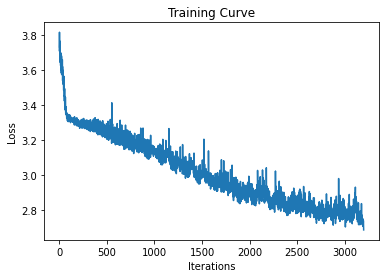

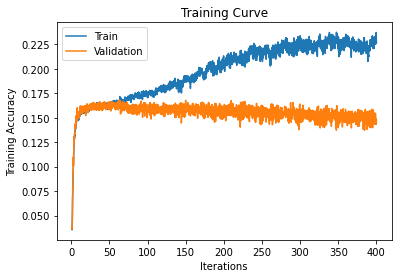

Final Training Accuracy: 0.22757677733898163
Final Validation Accuracy: 0.14532871544361115
Total time:   94.88 s  Time per Epoch:   0.24 s 


In [ ]:
build_and_train_TSFRNN(
                       model_path=None,
                        noisy=True, num_epochs=400, batch_size=256, learning_rate=0.005,
                        backbone="alex", train_features=computed_features, val_features=val_computed_features, 
                        fc_mid=[256*27, 12*3], fc_out=None,
                        rnn_type=nn.RNN, rnn_layers=2, rnn_input_sz=3, rnn_hd_sz=NUM_CATEGORIES, 
                        rnn_nonlin="tanh", rnn_dropout=0.8,
                        from_epoch=0, save_every=5, use_cuda=True)

RNNDec(
  (fc_mids): ModuleList(
    (0): Linear(in_features=6912, out_features=120, bias=True)
  )
  (rnn): RNN(10, 100, num_layers=2, batch_first=True, dropout=0.8)
  (fc_outs): ModuleList(
    (0): Linear(in_features=100, out_features=34, bias=True)
  )
)
training...


  0%|          | 0/400 [00:00<?, ?it/s]

Epoch:1, Loss:3.5053, Train acc:0.0846, Val acc:0.0827
Epoch:2, Loss:3.4858, Train acc:0.1106, Val acc:0.1096
Epoch:3, Loss:3.4404, Train acc:0.1216, Val acc:0.1257
Epoch:4, Loss:3.4194, Train acc:0.1350, Val acc:0.1390
Epoch:5, Loss:3.4183, Train acc:0.1449, Val acc:0.1407
Epoch:6, Loss:3.3976, Train acc:0.1527, Val acc:0.1519
Epoch:7, Loss:3.3765, Train acc:0.1542, Val acc:0.1559
Epoch:8, Loss:3.3531, Train acc:0.1591, Val acc:0.1530
Epoch:9, Loss:3.3294, Train acc:0.1569, Val acc:0.1594
Epoch:10, Loss:3.3219, Train acc:0.1601, Val acc:0.1574
Epoch:11, Loss:3.3061, Train acc:0.1608, Val acc:0.1621
Epoch:12, Loss:3.2868, Train acc:0.1605, Val acc:0.1634
Epoch:13, Loss:3.2777, Train acc:0.1621, Val acc:0.1615
Epoch:14, Loss:3.2719, Train acc:0.1643, Val acc:0.1594
Epoch:15, Loss:3.2285, Train acc:0.1638, Val acc:0.1609
Epoch:16, Loss:3.2327, Train acc:0.1667, Val acc:0.1619
Epoch:17, Loss:3.2286, Train acc:0.1644, Val acc:0.1607
Epoch:18, Loss:3.1970, Train acc:0.1662, Val acc:0.1617
E

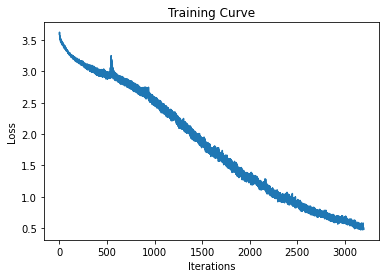

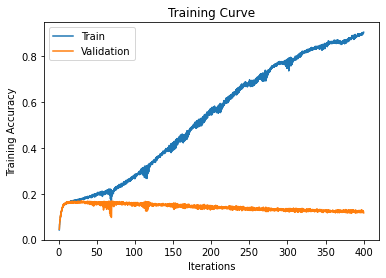

Final Training Accuracy: 0.8991584777832031
Final Validation Accuracy: 0.11649365723133087
Total time:   103.89 s  Time per Epoch:   0.26 s 


In [ ]:
build_and_train_TSFRNN(
                       model_path=None,
                        noisy=True, num_epochs=400, batch_size=256, learning_rate=1e-4,
                        backbone="alex", train_features=computed_features, val_features=val_computed_features, 
                        fc_mid=[256*27, 12*10], fc_out=[100, NUM_CATEGORIES],
                        rnn_type=nn.RNN, rnn_layers=2, rnn_input_sz=10, rnn_hd_sz=100, 
                        rnn_nonlin="tanh", rnn_dropout=0.8,
                        from_epoch=0, save_every=5, use_cuda=True)

In [ ]:
def get_accuracy_single_batch_TSFRNN(pred, target, debug=False, data=None, batch_size=None, visualize_errs=False):
  """pred is one-hot BSxMAX_NUM_CHARACTERSxNUM_CATEGORIES, true_encod is BSxMAX_NUM_CHARACTERS"""
  mask = torch.where(target == CHAR_CATEGORIES.index(PAD_TOK), torch.zeros(target.shape, device=device), torch.ones(target.shape, device=device))
  pred = pred.argmax(dim=-1)
  num_pads = torch.numel(mask) - mask.sum()
  correct = (pred*mask).eq(target*mask).sum().item() - num_pads
  total = mask.sum()
  if debug:
    print("pred:", pred)
    print("target:", target)

  if visualize_errs: # get up to 10 samples that were predicted wrong
    if data is None or batch_size is None:
      raise Exception("Must pass in data and batch_size for visual")
    label = noisy_val_data.get_label(0, batch_size=batch_size)
    errors, corrects = [], []
    for i in range(pred.shape[0]):
      pred_label = "".join(CHAR_CATEGORIES[idx] for idx in pred[i].to(torch.int64))
      print(pred_label, label[i])
      if not torch.all(pred[i].eq(target[i])) and len(errors) < 10:
        errors.append((data[i], pred_label, label[i]))
      if torch.all(pred[i].eq(target[i])) and len(corrects) < 10:
        corrects.append((data[i], pred_label, label[i]))
    fig = plt.figure(figsize=(25, 8))
    fig.suptitle("Wrong predictions and Correct predictions")
    for i in range(len(errors)):
      data, pred_label, label = errors[i]
      if use_cuda and torch.cuda.is_available():
        data = data.cpu()
      ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(data,(1, 2, 0)))
      ax.set_title("W pred="+pred_label.replace("$", "\$")+" target="+label)
    
    for j in range(len(corrects)):
      data, pred_label, label = corrects[j]
      if use_cuda and torch.cuda.is_available():
        data = data.cpu()
      ax = fig.add_subplot(4, 5, j+i+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(data,(1, 2, 0)))
      ax.set_title("C pred="+pred_label.replace("$", "\$")+" target="+label)
  return correct/total

atgpv$$p$3$n 2fvma
bhkj$$$$$$4k 22gn
c8vmxpa$$$bv 28c9va
wpkb$$$$$$$8 2as
jrw8p$$$$qev 2ai
z8au$$$$$vg2 2bah
w$bm3e$2kt$v 2bxmt33y
wx7ts$$$v$c$ 2enfwaa
wzdg$$pb$$cu 2h4emp
vpjh$$$$$$g2 2htb
w$$g$$$$$$$x 2ksx
wpaj9$$$$$6v 2ix
yvbutna$$$vg 2q9tat42
jqj5v$w$$$ne 2wpzbwk9
wcci$t$$$$u8 3yn
dec$$$$$$$$2 3cn
bvpa$$$$$$rk 3kwn
w$ggx$$$uycn 33bp
gmqjwe$$$$sp 36zev
ahqcrs$$$$5g 372pbuzqf
wcpbww$$$$$f 3dhf4suu
wkdfwewv$$32 3gtw5my
spbnf$9$$f$n 3mpgqnxz
wrgdr$$$b$3$ 3ujcj
gwf$$$$$$$$g 4uif9
wvrvws$$g$st 4vv
wmvh$$$u$$uk 4dnvkq
wrj$hyu$$$$$ 4hkv2zz7
jzyey$vf$$5$ 4hyj
wx6j$$$$$$7s 4jxm7
kv3gn$$$t$$g 4kcufh
wnpkzrh$$$cp 4kyrym
wrhcjf#q$$u9 4rpwzpn
yzb$$$$$$$ug 4saih
iqdh#$w$$9$f 4uzhcswgw
wph$tf$$bne3 4xayyq
wzb$ae$$$$uu 4xqhse
mmv$82v$$$$$ 4yr6p4
wp$r$s$$$$b$ 4zgnx5b3
vffkw$u$$$bf 4zhmz
wt$mmuf$$$ug 59wpvpnj4
wuuycajc$33# 5b92uqj
wyi53$$$$$bb 5chye
sh2$$$r$$$62 5ct7
wheqc$$$$$ek 5ctmg
wrbf$b$$$$ud 5ewk
xvvb$cgu$$gw 5eeb
bpacn$$$$$$2 5fkxy
gi2$z$b$$$ry 5gffdw3e
byyy3$t$$$$2 5meseeh
vz7pj$kb$$s$ 5mk3v

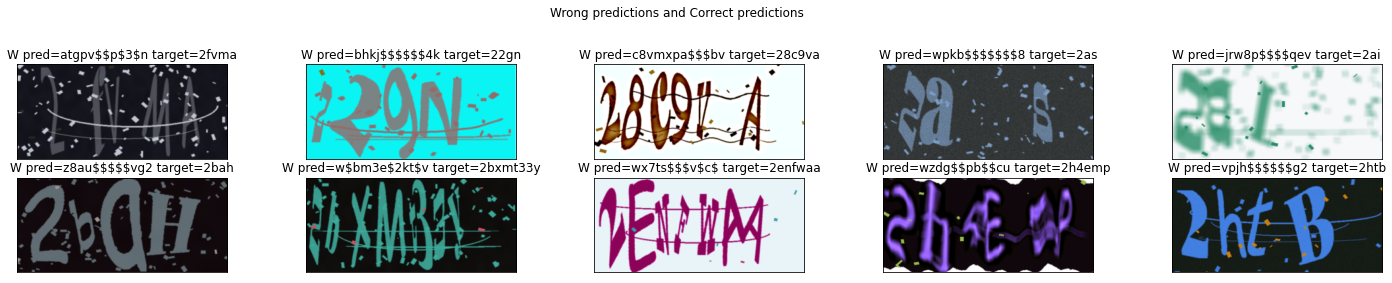

In [ ]:
# Visualize errors
batch=256
tmp_model = RNNDec(fc_mid=[256*27, 12*100], fc_out=None,
                  rnn_type=nn.RNN, rnn_layers=2, rnn_input_sz=100, rnn_hd_sz=NUM_CATEGORIES, 
                  rnn_nonlin="tanh", rnn_dropout=0.8)
tmp_model.load_state_dict(torch.load("results/models/TSFRNN_models/n_lr=0.0001_bs=256_bk=alex_rt=RNN_do=0.8_fcm=6912_1200_fco=/_100.pt"))
val_loader = torch.utils.data.DataLoader(noisy_val_data, 
                                          batch_size=batch, 
                                          num_workers=0,
                                          shuffle=False)
data, encod = iter(val_loader).next()
out = tmp_model(val_computed_features[0])
print("Accuracy over 1 batch: ", get_accuracy_single_batch_TSFRNN(out, encod, data=data, batch_size=batch, visualize_errs=True))
del tmp_model, val_loader, data, out, encod

### With Trevor's Infinite CAPTCHA Machine

In [ ]:
from src.scripts.captchas_gen.captcha.image import ImageCaptcha
import random
random.seed(360)

def get_random_string(length):
    # choose from all lowercase letter
    letters = "abcdefghjkmnpqrstuvwxyz" + "ABCDEFGHIJKLMNPQRSTUVWXYZ" + "23456789" + "     "
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

class RNNCacheSet():
    def __init__(self, size, period):
        self.size = size
        self.cached = [] # cached images
        self.labels = None # tensor
        self.period = period
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            # transforms.Grayscale(),
            transforms.ToTensor()
        ])
        self.flush()
    def flush(self):
        self.cached.clear()
        labels=[]
        for index in range(self.period):
            label = get_random_string(4)#random.randint(4, 9))
            data = self.IC.generate_image(label)
            data = self.transform(data)
            self.cached.append(data)
            labels.append(label.lower().replace(" ",""))
        self.labels = labels_to_encoding(labels=labels,one_hot=False)

    def __getitem__(self, index):
        index = index % self.period
        data = self.cached[index]
        label = self.labels[index]
        return data, label

    def __len__(self):
        return self.size
        
class RNNFrozenSet():
    def __init__(self, size):
        self.size = size
        self.cached = []
        self.labels = None # tensor
        self.period = size
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            # transforms.Grayscale(),
            transforms.ToTensor()
        ])
        self.flush2()
    def flush2(self):
        self.cached.clear()
        labels=[]
        for index in tqdm(range(self.period)):
            label = get_random_string(4) #random.randint(4, 9))
            data = self.IC.generate_image(label)
            data = self.transform(data)
            self.cached.append(data)
            labels.append(label.lower().replace(" ",""))
        self.labels = labels_to_encoding(labels=labels,one_hot=False)

    def __getitem__(self, index):
        index = index % self.period
        data = self.cached[index]
        label = self.labels[index]
        return data, label

    def __len__(self):
        return self.size

In [ ]:
%time val_set = RNNFrozenSet(800)

  0%|          | 0/800 [00:00<?, ?it/s]

CPU times: total: 3min 21s
Wall time: 34 s


In [ ]:
def compute_backbone_features(tsf_net, data_loader):
  computed_features = []
  for imgs, labels in tqdm(data_loader):
    feature=tsf_net.features(imgs.cuda())
    feature=feature.detach()
    assert feature.requires_grad==False
    computed_features.append(feature)
  return computed_features

def get_accuracy_TSFRNN(model, data_loader, features, debug=False):
  correct = 0
  total = 0
  for i, (data, target) in enumerate(data_loader):

    if use_cuda and torch.cuda.is_available():
      data = data.cuda()
      target = target.cuda()

    out = model(features[i])

    mask = torch.where(target == CHAR_CATEGORIES.index(PAD_TOK), torch.zeros(target.shape, device=device), torch.ones(target.shape, device=device))
    pred = out.argmax(dim=-1)
    num_pads = torch.numel(mask) - mask.sum()
    correct += (pred*mask).eq(target*mask).sum().item() - num_pads
    total += mask.sum()

  if debug:
    print("pred:", pred)
    print("target:", target)

  return correct/total

In [ ]:
if use_cuda and torch.cuda.is_available():
  num_workers = 0
  shuffle = False
else:
  num_workers=2
  shuffle=True

model_folder_path="results/models/TSFRNN_models/"
bkb_models={"alex": models.alexnet(pretrained=True)}

def build_and_train_IFTRNN(
                        model_path=None,
                        noisy=True, num_epochs=5, batch_size=64, learning_rate=1e-3,
                        backbone="", train_size=(1000, 1000),
                        fc_mid=None, fc_out=None, fc_dropout=0.5, teach_prob_f=lambda i: 1,
                        rnn_type=nn.RNN,  rnn_input_sz=53352, rnn_hd_sz=NUM_CATEGORIES, 
                        rnn_nonlin="tanh", rnn_dropout=0.8,
                        from_epoch=1, save_every=5, use_cuda=False):
    # model path
    if model_path is None:
      fcm=""
      fco=""
      if fc_mid is not None:
        fcm = "_".join(str(i) for i in fc_mid)
      if fc_out is not None:
        fco = "_".join(str(i) for i in fc_out)
      model_path="n" + f"_lr={learning_rate}_ts={train_size[0]}_{train_size[1]}_bs={batch_size}_bk={backbone}_rt={rnn_type.__name__}_fdo={fc_dropout}_do={rnn_dropout}_fcm={fcm}_fco={fco}" if noisy \
            else "d" + f"_lr={learning_rate}_ts={train_size[0]}_{train_size[1]}_bs={batch_size}_bk={backbone}_rt={rnn_type.__name__}_fdo={fc_dropout}_do={rnn_dropout}_fcm={fcm}_fco={fco}"
    os.makedirs(model_folder_path+model_path, exist_ok=True)

    # save parameters to json file
    params = locals()
    params["rnn_type"] = rnn_type.__name__
    if "teach_prob_f" in params:
      params.pop("teach_prob_f")
    if "train_features" in params:
      params.pop("train_features")
    if "val_features" in params:
      params.pop("val_features")
    with open(os.path.join(model_folder_path, model_path, 'params.json'), 'w') as fp:
      json.dump(params, fp, indent=4)
    
    torch.manual_seed(360)

    train_set = RNNCacheSet(*train_size)
    val_loader = torch.utils.data.DataLoader(val_set, 
                                              batch_size=batch_size, 
                                              num_workers=num_workers,
                                              shuffle=shuffle)
    print("Loading backbone...")
    bkb_model = bkb_models[backbone]
    model = RNNDec(
                 fc_mid=fc_mid, fc_out=fc_out, fc_dropout=fc_dropout,
                 rnn_type=rnn_type, rnn_input_sz=rnn_input_sz, rnn_hd_sz=rnn_hd_sz, 
                 rnn_nonlin=rnn_nonlin, rnn_dropout=rnn_dropout)
    model.init_weights()
    print(model)
    if from_epoch > 0:
      model.load_state_dict(torch.load(os.path.join(model_folder_path,model_path,f"_{from_epoch}.pt")))

    if use_cuda and torch.cuda.is_available():
      model.cuda()

    print("training...")
    train_IFTRNN(model, train_set, val_loader,
             backbone=bkb_model,
             model_path=model_path, teach_prob_f=teach_prob_f,
             noisy=noisy, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate,
             from_epoch=from_epoch,save_every=save_every, use_cuda=use_cuda)
    
    if use_cuda and torch.cuda.is_available():
      del model
      del val_loader
      gc.collect()
      torch.cuda.empty_cache()
    

def train_IFTRNN(model, train_set, val_loader,
             backbone=None,
             model_path=None, teach_prob_f=lambda i: 1,
             noisy=True, num_epochs=5, batch_size=64, learning_rate=1e-3,
             from_epoch=0, save_every=5, use_cuda=False):
    torch.manual_seed(360)
    criterion = nn.NLLLoss(ignore_index=CHAR_CATEGORIES.index(PAD_TOK))
    logsoftmax = nn.LogSoftmax(dim=1)
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-4)
    outputs, losses, train_acc, val_acc = [], [], [], []
    
    val_computed_features = compute_backbone_features(backbone, val_loader)
    
    start_time=time.time()
    for epoch in tqdm(range(from_epoch+1, num_epochs+from_epoch+1)):
        print("Prep data...")
        train_set.flush()
        train_loader = torch.utils.data.DataLoader(train_set, 
                                              batch_size=batch_size, 
                                              num_workers=num_workers,
                                              shuffle=shuffle)
        computed_features = compute_backbone_features(backbone, train_loader)
        print("Done")

        num_batches = 0
        for i, (data, label) in enumerate(train_loader):
            out = model(computed_features[i], target=label, teach_prob=teach_prob_f(epoch))
            if(out.shape[1] != MAX_NUM_CHARACTERS or out.shape[2] != NUM_CATEGORIES):
              raise Exception("Output shape incorrect. Got:"+str([str(i) for i in out.shape]))
            loss = criterion(logsoftmax(out.flatten(end_dim=1)), label.to(torch.int64).flatten())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if use_cuda and torch.cuda.is_available():
              loss = loss.cuda()

            losses.append(loss.item())
            
            # minibatch train acc
            mask = torch.where(label == CHAR_CATEGORIES.index(PAD_TOK), torch.zeros(label.shape, device=device), torch.ones(label.shape, device=device))
            pred = out.argmax(dim=-1)
            num_pads = torch.numel(mask) - mask.sum()
            mini_batch_correct = (pred*mask).eq(label*mask).sum().item() - num_pads
            Mini_batch_total = mask.sum()
            train_acc.append(float(mini_batch_correct / Mini_batch_total))
            val_acc.append(val_acc[-1] if len(val_acc)> 0 else 0)

            # train_acc.append(float(get_accuracy_TSFRNN(model, train_loader, computed_features).item()))
            num_batches += 1

        val_acc = val_acc[:-1]
        val_acc.append(float(get_accuracy_TSFRNN(model, val_loader, val_computed_features).item()))
        print('Epoch:{}, Loss:{:.4f}, Train acc:{:.4f}, Val acc:{:.4f}'.format(epoch, float(loss), train_acc[-1], val_acc[-1]))
        
        if epoch % save_every == 0 or epoch == 1 or epoch == from_epoch+num_epochs:
            print("teach_prob=", teach_prob_f(epoch))
            torch.save(model.state_dict(), model_folder_path+model_path+"/_"+str(epoch)+".pt")
    
    end_time= time.time()
    np.savetxt(model_folder_path+model_path+f"/loss_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                losses,
                delimiter =", ", 
                fmt ='% s')
    np.savetxt(model_folder_path+model_path+f"/tacc_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                train_acc,
                delimiter =", ", 
                fmt ='% s')
    np.savetxt(model_folder_path+model_path+f"/vacc_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
                val_acc,
                delimiter =", ", 
                fmt ='% s')
    
    # plotting
    plt.title("Training Curve")
    iters = range(len(losses))
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig(model_folder_path+model_path+f"/loss_{from_epoch+1}_to_{from_epoch+num_epochs}.jpg")
    plt.show()

    iters = np.linspace(from_epoch+1, from_epoch+num_epochs, num=num_batches*(num_epochs))
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.savefig(model_folder_path+model_path+f"/acc_{from_epoch+1}_to_{from_epoch+num_epochs}_acc={val_acc[-1]:.2f}.jpg")
    plt.show()

    print("Final Training Accuracy: {}".format(get_accuracy_TSFRNN(model, train_loader, computed_features)))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))
    
    del train_loader, computed_features, val_computed_features

Loading backbone...
RNNDec(
  (dropout): Dropout(p=0.8, inplace=False)
  (fc_mids): ModuleList(
    (0): Linear(in_features=6912, out_features=12, bias=True)
  )
  (rnn): LSTMCell(1, 35)
)
training...


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:1, Loss:3.5094, Train acc:0.1469, Val acc:0.1422
teach_prob= 0.033895113513574104
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:2, Loss:3.4941, Train acc:0.1693, Val acc:0.1821
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:3, Loss:3.4619, Train acc:0.1896, Val acc:0.2009
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:4, Loss:3.4211, Train acc:0.2274, Val acc:0.2169
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:5, Loss:3.3946, Train acc:0.2178, Val acc:0.2151
teach_prob= 0.18136041286564586
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:6, Loss:3.3799, Train acc:0.2199, Val acc:0.2151
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:7, Loss:3.3685, Train acc:0.2138, Val acc:0.2151
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:8, Loss:3.3731, Train acc:0.2136, Val acc:0.2151
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:9, Loss:3.3200, Train acc:0.2190, Val acc:0.2140
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:10, Loss:3.3118, Train acc:0.2148, Val acc:0.2177
teach_prob= 0.3956124250860895
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:11, Loss:3.3078, Train acc:0.2146, Val acc:0.2175
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:12, Loss:3.2796, Train acc:0.2185, Val acc:0.2191
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:13, Loss:3.2984, Train acc:0.2229, Val acc:0.2220
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:14, Loss:3.2814, Train acc:0.2235, Val acc:0.2188
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:15, Loss:3.2534, Train acc:0.2278, Val acc:0.2204
teach_prob= 0.6487212707001282
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:16, Loss:3.2664, Train acc:0.2283, Val acc:0.2242
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:17, Loss:3.2832, Train acc:0.2206, Val acc:0.2223
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:18, Loss:3.2522, Train acc:0.2262, Val acc:0.2199
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:19, Loss:3.2194, Train acc:0.2313, Val acc:0.2185
Prep data...


  0%|          | 0/30 [00:00<?, ?it/s]

Done
Epoch:20, Loss:3.2014, Train acc:0.2411, Val acc:0.2167
teach_prob= 0.9477340410546757


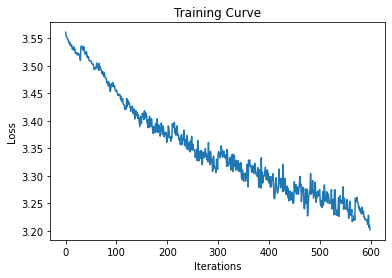

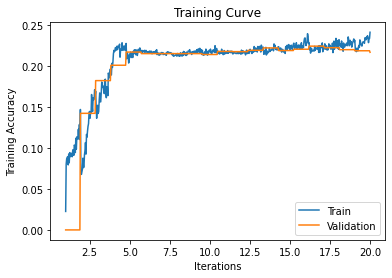

Final Training Accuracy: 0.23426395939086295
Final Validation Accuracy: 0.21665773968934118
Total time:   688.99 s  Time per Epoch:  34.45 s 


In [ ]:
batch_size=256
build_and_train_IFTRNN(
                        model_path=None, train_size=(256*30, 256),
                        noisy=True, num_epochs=20, batch_size=256, learning_rate=0.001,
                        backbone="alex", 
                        teach_prob_f = lambda i: np.exp(i/30)-1,
                        fc_mid=[256*27, 12*1], fc_out=None, fc_dropout=0.8,
                        rnn_type=nn.LSTMCell, rnn_input_sz=1, rnn_hd_sz=NUM_CATEGORIES, 
                        rnn_nonlin="tanh", rnn_dropout=0.8,
                        from_epoch=0, save_every=5, use_cuda=True)